# Analysing happiness around the world

The World Happiness Report is a landmark survey of the state of global happiness that ranks 156 countries by how happy their citizens perceive themselves to be. It is one of the publications of the United Nations Sustainable Developement Solutions Network.

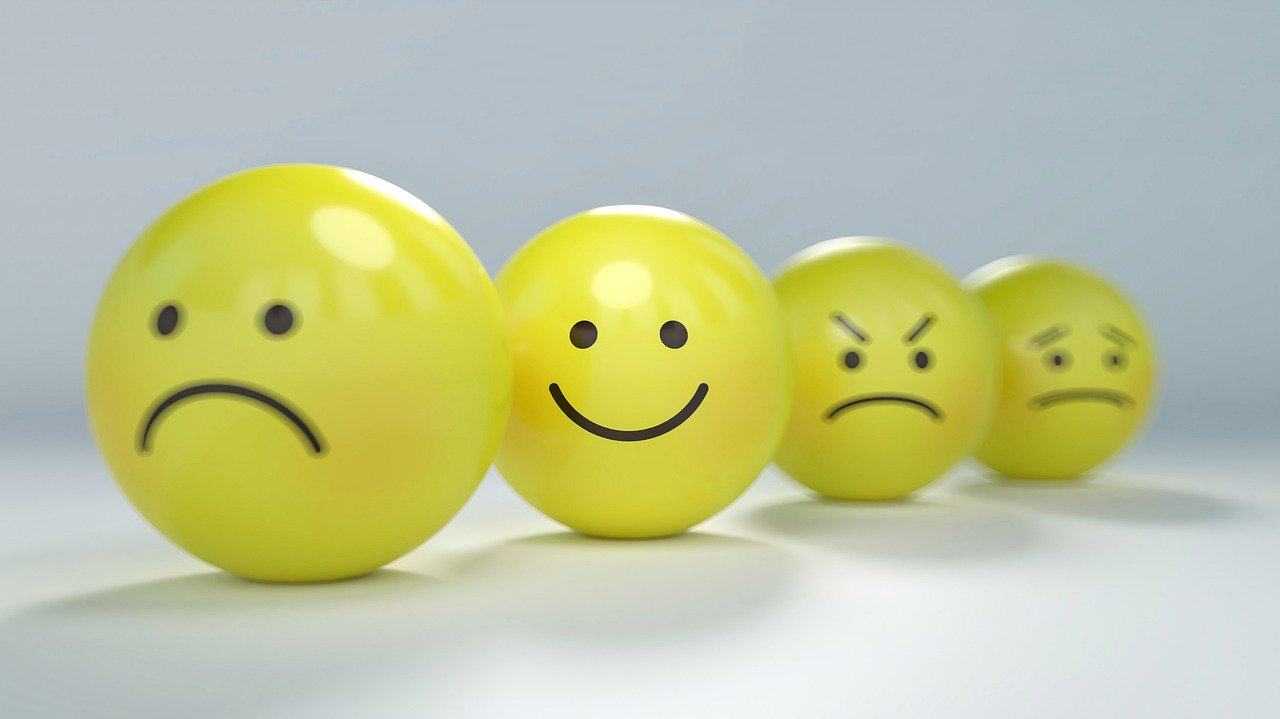

In [ ]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas_profiling
from IPython.display import HTML
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
PATHS = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        PATHS.append(os.path.join(dirname, filename))
PATHS.sort()

In [ ]:
df = pd.read_csv(PATHS[-1])
pio.templates.default = "plotly_dark"

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "black",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# Table Of Contents

 1. [Structure and Summary](#header-one)
 2. [Happiest countries/regions](#header-two)
    * [Contribution of explained variables](#header-two-subsection-one)
 3. [Unhappiest countries/regions](#header-three)
    * [Contribution of explained variables](#header-two-subsection-one)
 4. [Distributions of regions](#header-four)
    * [Happiness score by region](#header-four-subheader-one)
    * [Distribution of features by region](#header-four-subheader-two)
 5. [k-means clustering](#header-five)
    * [Optimal k -means](#header-five-subheader-one) 
 6. [Distribution of happiness score](#header-six)
 7. [Feature interactions and correlations](#header-seven)
 8. [Predicting happiness using linear regression](#header-eight)

<a id="header-one"></a>
## Structure and Summary

In [ ]:
print("There are {} rows and {} columns in the dataset.".format(df.shape[0], df.shape[1]))

In [ ]:
df.rename({"Ladder score": "Happiness score"},axis=1, inplace=True)

In [ ]:
report  = pandas_profiling.ProfileReport(df, title="Happiness Profile")

In [ ]:
df.info()

The good news is that the data has no missing values. Therefore, we do not need to perform any cleaning techniques. Also, some of the column names have the word "Explained" prefixed to it. This leads me to believe that these variables were possibly derived from some model.

<a id="header-two"></a>
## Happiest countries/regions

In [ ]:
fig = px.bar(data_frame = df.nlargest(10,"Happiness score"),
             y="Country name",
             x="Happiness score",
             orientation='h',
             color="Country name",
             text="Happiness score",
             color_discrete_sequence=px.colors.qualitative.D3)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='inside', 
                  marker_line_color='rgb(255,255,255)', 
                  marker_line_width=2.5, 
                  opacity=0.7)
fig.update_layout(width=800,
                  showlegend=False,
                  title="Top 10 happiest countries",
)
fig.show()

fig = px.bar(data_frame = df.nlargest(10,"Happiness score"),
             y="Country name",
             x="Happiness score",
             orientation='h',
             color="Regional indicator",
             text="Happiness score",
             color_discrete_sequence=px.colors.qualitative.D3)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='inside', 
                  marker_line_color='rgb(255,255,255)', 
                  marker_line_width=2.5, 
                  opacity=0.7)
fig.update_layout(width=800,
                  yaxis=dict(autorange="reversed"),
                  title="Top 10 happiest countries colored by region")
fig.show()

9 out of the top 10 countries are from the West Europe region. New Zealand is the only non Western European country.

<a id="header-two-subsection-one"></a>
### Contribution of explained variables

In [ ]:
explained_features = df.filter(regex="Explained").columns.tolist()
explained_features.append("Dystopia + residual")
my_list = []
for f,c in zip(explained_features, px.colors.qualitative.D3):
    my_list.append(go.Bar(y=df.nlargest(10,"Happiness score")["Country name"].values,
                          x=df.nlargest(10,"Happiness score")[f].values,
                          name=f,
                          marker=dict(color=c),
                          orientation="h"))
fig = go.Figure(data=my_list)
fig.update_traces(marker_line_color='rgb(255,255,255)',
                  marker_line_width=2.5, opacity=0.7)
fig.update_layout(
                width=900,
                barmode='stack',
                 yaxis=dict(autorange="reversed"),
                )
fig.show()

<a id="header-three"></a>
## Unhappiest countries/regions

In [ ]:
fig = px.bar(data_frame = df.nsmallest(10,"Happiness score"),
             y="Country name",
             x="Happiness score",
             orientation='h',
             color="Country name",
             text="Happiness score",
             color_discrete_sequence=px.colors.qualitative.D3)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='inside', 
                  marker_line_color='rgb(255,255,255)', 
                  marker_line_width=2.5, 
                  opacity=0.7)
fig.update_layout(width=800,
                  showlegend=False,
                  title="Bottom 10 happiest countries",
                 )
fig.show()

fig = px.bar(data_frame = df.nsmallest(10,"Happiness score"),
             y="Country name",
             x="Happiness score",
             orientation='h',
             color="Regional indicator",
             text="Happiness score",
             color_discrete_sequence=px.colors.qualitative.D3)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='inside', 
                  marker_line_color='rgb(255,255,255)', 
                  marker_line_width=2.5, 
                  opacity=0.7)
fig.update_layout(width=800,
                  yaxis=dict(autorange="reversed"),
                  title="Bottom 10 happiest countries colored by region",
                  )
fig.show()

7 out of 10 countries are from the Sub-Saharan region in Africa. This is unsurprising because this region has been frequently affected by diseases, has lacked proper human resources, infrastructure and has had a long history of civil unrest. 

What came as a shocker to me is that my own country, India is ranked among the bottom 10 countries in the world. Inspite of ranking 5th among the top economies in the world, people seem to be very unhappy in India.

<a id="header-three-subsection-one"></a>
### Contribution of explained variables

In [ ]:
explained_features = df.filter(regex="Explained").columns.tolist()
explained_features.append("Dystopia + residual")
my_list = []
for f,c in zip(explained_features, px.colors.qualitative.D3):
    my_list.append(go.Bar(y=df.nsmallest(10,"Happiness score")["Country name"].values,
                          x=df.nsmallest(10,"Happiness score")[f].values,
                          name=f,
                          marker=dict(color=c),
                          orientation="h"))
fig = go.Figure(data=my_list)
fig.update_traces(marker_line_color='rgb(255,255,255)',
                  marker_line_width=2.5, opacity=0.7)
fig.update_layout(
                width=900,
                barmode='stack',
                 yaxis=dict(autorange="reversed"),
                )
fig.show()

<a id="header-four"></a>
## Distribution of regions

In [ ]:
fig = px.pie(values = df["Regional indicator"].value_counts(),
             names= df['Regional indicator'].unique(),
             title="Percentage of contribution of regions",
             color_discrete_sequence=px.colors.qualitative.Dark2,
             )

fig.update_traces(marker_line_color='rgb(255,255,255)', 
                  marker_line_width=2.5, 
                  opacity=0.7)
fig.update_layout(width=800)
fig.show()

Interestingly, the biggest chunk of regions contributing to the report also happens to belong to Western Europe.

<a id="header-four-subheader-one"></a>
### Happiness score by region

In [ ]:
fig = px.box(df,
             x="Happiness score",
             y="Regional indicator",
             color="Regional indicator",
             color_discrete_sequence=px.colors.qualitative.Pastel_r,
             template="plotly_dark")
fig.update_traces(boxmean=True,
                  whiskerwidth=0.8,
                  marker_size=2,
            line_width=2.5
                  )
fig.update_layout(height=600,
                  width=800,
                  showlegend=True,
                  yaxis= dict(showticklabels = False),
                  title="Distribution of happiness score by region")
fig.show()

Although Western Europe has so many countries in the top 10 list, the mean and median of North America and ANZ region (7.17, 7.22 respectively) is slightly higher than Western Europe (6.90, 7.09) respectively.

<a id="header-four-subheader-two"></a>
### Distribution of features by region

In [ ]:
 def feature_analysis(df, feature):               
    grouped_df = df.groupby(["Regional indicator"]).agg({feature : np.mean}).reset_index()
    template='%{text:0.2f}'
    tickformat = None
    if grouped_df[feature].min() < 1:
        template='%{text:0.2%}'
        tickformat = ".2%"
        
    fig = px.bar(grouped_df,
                 x="Regional indicator",
                 y=feature,
                 color="Regional indicator",
                 text=feature,
                 color_discrete_sequence=px.colors.qualitative.D3,
                 template="plotly_dark"
                )

        
    fig.update_traces(texttemplate=template, 
                      textposition='outside', 
                      marker_line_color='rgb(255,255,255)', 
                      marker_line_width=2.5, 
                      opacity=0.7)

    fig.update_layout(showlegend=False,
                      title="Region vs {}".format(feature),
                      yaxis=dict(tickformat=tickformat))

    fig.show()
    
    return None

In [ ]:
feature_names = ["Logged GDP per capita",
                 "Social support",
                 "Healthy life expectancy",
                 "Freedom to make life choices",
                 "Generosity",
                 "Perceptions of corruption"]
for feature in feature_names:
    feature_analysis(df, feature)

A few observations to note:

* Sub-Saharan countries reported lowest GDP per capita, social support and healthy life expectancy. This is in accordance with a few points mentioned in this analysis before.
* The Middle East and North African countries have reported lowest freedom to make life choices. It should be noted that these countries do constitute the gulf countries such as   Iraq, Syria and Saudi Arabia where there have been news in the past about suppression of free speech and human rights violations.
* North American and ANZ region and South East Asia report the highest levels of generosity. Perhaps folks living in these regions engage with NGOs and charitable organizations     on a regular basis.
* Finally, North American and ANZ region also reports the lowest levels of perceived corruption. The number is significantly lower when compared to other regions.


<a id="header-five"></a>
## k-means clustering

In [ ]:
k = 6
model = KMeans(k)

In [ ]:
X = df[feature_names].values
model.fit(X)

In [ ]:
labels = model.labels_.tolist()
labels = list(map(lambda s: str(s), labels))
fig = px.scatter_3d(df,
                 x="Generosity",
                 y="Healthy life expectancy",
                 z="Perceptions of corruption",
                 color=labels,
                 color_discrete_sequence=px.colors.qualitative.G10,
                 hover_data = {
                     "Country name": True
                 }
            )

fig.update_traces(opacity=0.7,
                      marker_line_color='rgb(255,255,255)', 
                      marker_line_width=2.5
                      )
fig.update_layout(width=800,
                  legend=dict(title="Cluster id"),
                  title="K means clustering of happiness report (k = {})".format(k))
fig.show()

In [ ]:
fig = px.scatter_3d(df,
                 x="Generosity",
                 y="Healthy life expectancy",
                 z="Perceptions of corruption",
                 color="Regional indicator",
                 color_discrete_sequence=px.colors.qualitative.G10
            )

fig.update_traces(opacity=0.7,
                  )
fig.update_traces(mode='markers',marker_line_color='rgb(255,255,255)', 
                      marker_line_width=2.5)
fig.update_layout(width=800,
                  title="Scatterplot of happiness report by region".format(k))
fig.show()

Not too shabby considering 6 was a random guess.

<a id="header-five-subheader-one"></a>
### Optimal k value

In [ ]:
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(X)       
visualizer.show()  

It looks like the elbow is at 7 so we actually weren't very far off.

<a id="header-six"></a>
## Distribution of happiness score

In [ ]:
fig = px.histogram(df["Happiness score"],
                   marginal="box")
fig.update_traces(opacity=0.7,
                      marker_line_color='rgb(255,255,255)', 
                      marker_line_width=2.5
                      )
fig.update_layout(showlegend=False,
                  title="Distribution of happiness scores (skew: {:.3f})".format(df["Happiness score"].skew()),
                  width=800)
fig.show()

From the histogram, we can see that the happiness scores are slightly skewed to the left.

<a id="header-seven"></a>
## Feature interactions and correlations

In [ ]:
report.to_notebook_iframe()

If we look at the interatctions and correlations tabs we see that between our 6 features, 4 of them have a positive correlation with the happiness score (GDP, social support, healthy life, freedom of choice). Generosity doesn't seem to have a particular correlation whereas corruption has a slight negative correlation.

<a id="header-eight"></a>
## Predicting happiness using linear regression

In [ ]:
y = df["Happiness score"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
y_fitted = model.predict(X_train)
y_preds = model.predict(X_test)

In [ ]:
print("Mean squared error for the training data is: {:.4f}".format(mean_squared_error(y_fitted, y_train)))

In [ ]:
print("Mean squared error for the test data is: {:.4f}".format(mean_squared_error(y_preds, y_test)))

It looks like we got pretty low mean squared error values. Feel free to fork and experiment with different models, preprocessing/feature engineering techniques to improve on the score.

I hope you enjoyed this notebook. Until next time. 😊